# Reinforcement Learning Homework

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menu bar, select Cell $\rightarrow$ Run All). You can also perform the two operations in one step (in the menu bar, select Kernel $\rightarrow$ Restart & Run All).

Make sure you fill in any place (or anywhere that you want in the code) that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run). This is a reminder for you to complete all parts of the notebook. You can also send an incomplete notebook, but please remove all 'raise'-lines in any case.

You are not required to modify the code only where the line `YOUR CODE HERE` appears. In fact you can modify the given function and code as you want. Those are just reminders.

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your code, since this is the way we will do it before evaluating your notebook!

Fill in your name and ID number (matricola) below:

In [12]:
NAME = 'Gionata Grotto'
ID_number = int('2052418')

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# First Homework - Multi-Armed Bandits and Dynamic Programming

The present homework contains 2 exercises, one related to Multi-Armed Bandit problem and the other to Dynamic Programming.

- Delivery date: 26/10/2022

- Submission deadline: 09/11/2022 (23:59)

# Nonstationary Multi-Armed Bandits

The first part of the homework deals with the Multi Armed Bandit Problem.
In particular, the 10-armed testbed environment is exploited in order to understand what happens when dynamics are introduced in the arm rewards.
In order to complete the following exercise you will have to **modify** the 10-armed testbed environment in such a way that the mean values $\mu(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:

$$ \mu_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$\mu_t(a) = \mu_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Then $$ q_t(a) =  \mathcal{N}(\mu_t(a), 1) \qquad \forall a \in \mathcal{A}$$

Assume $\sigma = 0.1$.

Compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'rewards' which is a numpy nd-array containing the average (over different runs) rewards of the two algorithms! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

In [13]:
# Install packages in ipython
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
## Credits and imports

#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns
from scipy.stats import poisson

For your convenience, the code discussed in the first "tutorial lesson" is reported below. Feel free to modify the code as you wish in order to achieve the required result.


In [15]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) 

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
        

    def reset(self):

        # mean value expected from selecting one of the k bandits
        self.mean_arm = np.zeros(self.k)

        self.q_estimation = np.zeros(self.k)

        self.action_count = np.zeros(self.k)

        # index of the best action
        # at every iteration it is updated
        self.best_action = np.argmax(self.mean_arm)

    def step(self, action):

        # get reward from sampled from the normal distribution sampled with mean
        # equals to the mean of the selected action and variance equal to 1
        reward = np.random.normal(self.mean_arm[action], 1)

        if self.sample_averages:
            # only sample average uses variable time so it can be updated inside
            # this if case
            self.time += 1
            # update number of time action is chosen
            self.action_count[action] += 1
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        else:
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])

        # update mean for each bandit
        self.mean_arm += np.random.normal(0,0.01,size=self.k)

        # select new best action from mean array
        self.best_action = np.argmax(self.mean_arm)

        return reward


def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)

    # cumulative average reward at every run
    cumulative_average_reward = np.cumsum(mean_rewards,axis=1)

    return mean_best_action_counts, mean_rewards, cumulative_average_reward

In [16]:
runs=500; time=5000

# list to build the bandits
# if True then build a bandit that uses the Sample Average algorithm
# if False then build a bandit that uses the Constant Step Size algorithm
sampleAverage = [True, False]

# bandits to compute
bandits = [Bandit(epsilon=0.1, sample_averages=sample) for sample in sampleAverage]


best_action_counts, rewards, cumul_reward = simulate(runs, time, bandits)

100%|██████████| 500/500 [02:06<00:00,  3.94it/s]


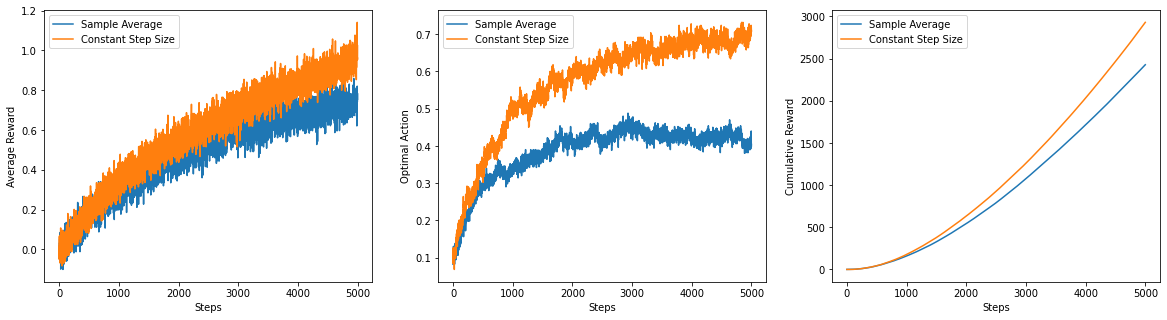

In [17]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for samp, reward in zip(sampleAverage, rewards):
    if samp:
        lbl = "Sample Average"
    else:
        lbl = "Constant Step Size"
    plt.plot(reward, label=lbl)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 3, 2)
for samp, counts in zip(sampleAverage, best_action_counts):
    if samp:
        lbl = "Sample Average"
    else:
        lbl = "Constant Step Size"
    plt.plot(counts, label=lbl)
plt.xlabel('Steps')
plt.ylabel('Optimal Action')
plt.legend()

plt.subplot(1, 3, 3)
for samp, cum_rew in zip(sampleAverage, cumul_reward):
    if samp:
        lbl = "Sample Average"
    else:
        lbl = "Constant Step Size"
    plt.plot(cum_rew, label=lbl)
plt.xlabel('Steps')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.show()

In [18]:
# HERE ENDS THE FIRST EXERCISE
assert rewards.shape == (2, 5000)

Comment your results in the cell below. Which algorithm performed best? With respsect to which metric? Why? [~15 lines]

The algorithm that performed better is the one that use constant step size (in the homework I used σ = 0.1). We can see in the plot that initially the 2 algorithms performed similarly but after 1000 steps the constant step size algorithm start to perform better. Indeed the average reward and the cumulative reward is higher. In the plot of the optimal action we can see clearly the difference in performance of the 2 algorithms: the sample average algorithm chose the best action about 40% of the time while the constant step size algorithm chose it about 70% of the time on the plot of the optimal action choice. The Sample Average algorithm uses as step size the inverse of the number of time that the specific action has been selected up to this point, so the step size get smaller at every selection of the action so at the n selection of action a the step size is 1/n where each reward has the same weight. So initially the step size is large enough to overcome initial condition and then became small enough to converge. This method perform better for the stationary problem where the probability rewards doesn't change over time. This is, however, a nonstationary problem indeed the mean reward of every action change at every iteration so there is a need to give more importance to the recent reward respect to the older ones. This because it is possible that an action at some point has a high mean reward and after n iterations the mean reward is now much smaller. To estimate the next action it is not important to the algorithm to know that in the past that action had a higher reward, it is important to know that know has a small possible reward and the algorithm shouldn't chose it. So using a constant step size each mean reward is weighted through time, each reward of action at n - i is indeed multiplied for a value lower that zero with exponent i so actions occurred in the distance past have lower relevance. This method is not guaranteed to converge but generally perform well in nonstationary problems.

# Jack against the nationwide company

The second part of the homework consists of a modification of the Jack's Car Rental problem discussed during the second "Tutorial Lecture".
One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to **shuttle one car to the second location for free**, while each additional car costs the usual $2\$$. Moreover, the nationwide car rental company has changed its policy on parking spaces: for each location now Jack can only park up to 10 vehicles free of charge. **If more than 10 cars are kept overnight at a location, then an additional cost of $4\$$ must be incurred** to use a second parking lot (independent of how many cars are kept there). The car rental company charges Jack with the additional parking lots price first thing in the morning, **before any possible moving of cars**.
In order to fulfill the exercise requirements, you need to **modify and solve** the new instance of the Jack's car rental problem with a **Value Iteration** algorithm.
Generate a subplot with six cells as the one seen in the "Tutorial Lecture" with the figures of 5 policies at different iterations: #0, #7, #14, #21, and the last (optimal!) one. In the sixth box plot the optimal value-function.
Use $\texttt{constant}$_$\texttt{returned}$_$\texttt{cars}$ = **True**.

**Optional assignment:** 
consider an additional cost, when the customers return more cars than a facility is able to accomodate (MAX_CARS) Jack has to pay a tow truck to carry them to a third location of the nationwide company. Suppose that the truck can carry all the extra cars, and it costs 4 \$ for a single location. Be careful of where you encode this in the script. 

If you decide to implement this extra point, make sure to set $\text{OPTIONAL}$_$\text{POINT}$ = **True**, otherwise leave it to **False**.


##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'policy' which is a numpy nd-array containing the optimal action for each pair of states, as in the notebook of the second "Tutorial Lecture"! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

max value change 334.64950688244676
max value change 146.66337702191663
max value change 95.53961122330168
max value change 65.04868346900105
max value change 47.80117150277721
max value change 37.755739392825944
max value change 29.751806644652504
max value change 23.499309069073888
max value change 18.61909786995858
max value change 15.216929332639097
max value change 12.879427297698442
max value change 10.873986440007855
max value change 9.199386169523393
max value change 7.776948391767121
max value change 6.570074582964082
max value change 5.548385521552916
max value change 4.684673560265594
max value change 3.9575515710261584
max value change 3.401053286742467
max value change 2.9124101971601704
max value change 2.490677626245315
max value change 2.1288488424257253
max value change 1.8191273214314947
max value change 1.5543565215409103
max value change 1.3294868223703133
max value change 1.1373019343888586
max value change 0.9729038628956914
max value change 0.8322605070113696
max

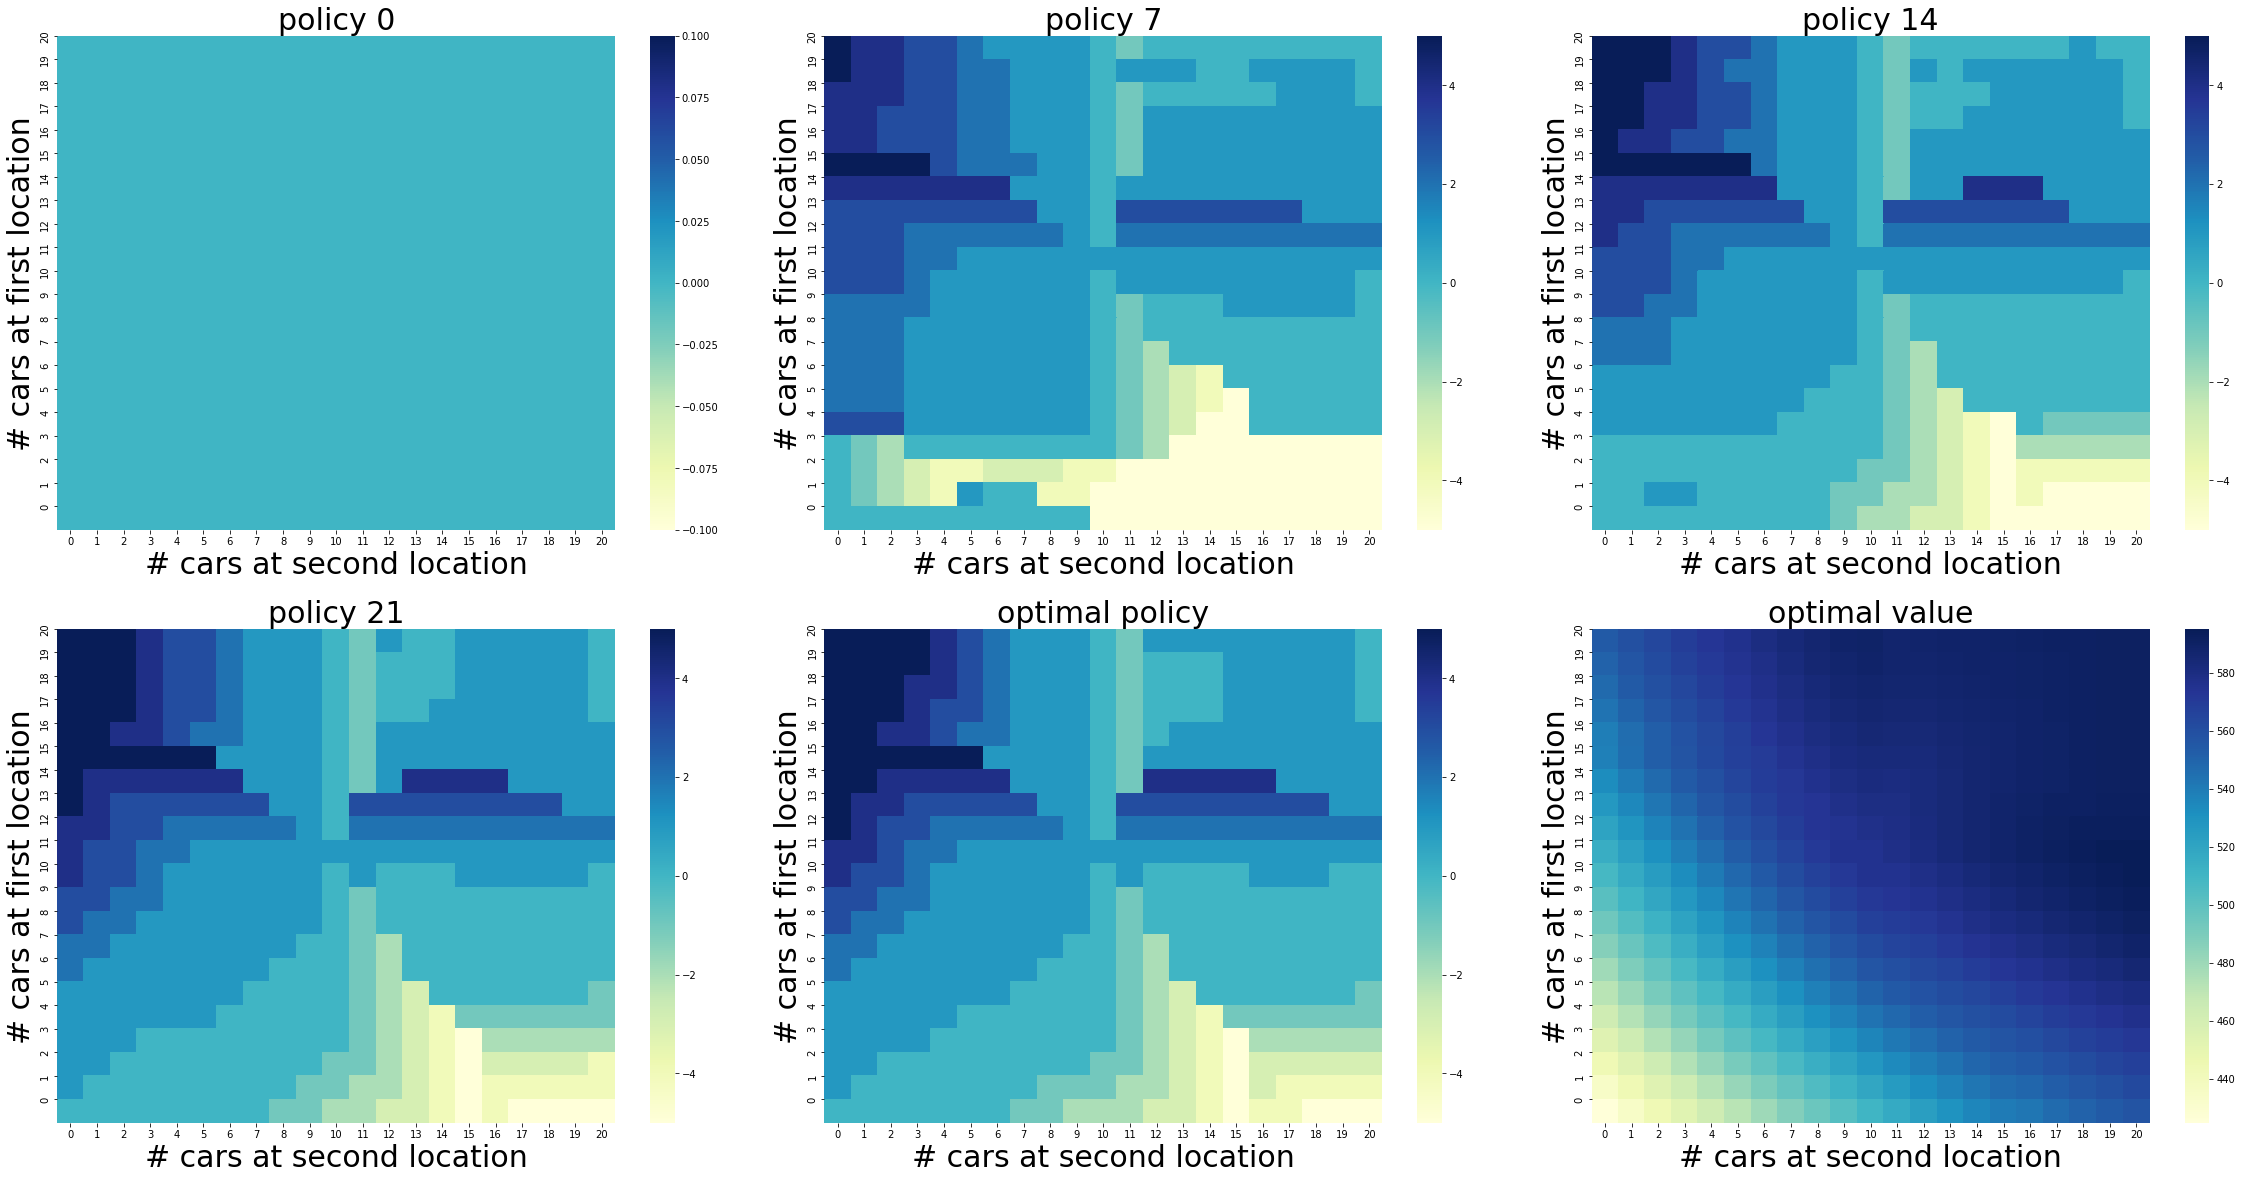

max value change 330.7655828194039
max value change 146.6626573182869
max value change 95.53542095095156
max value change 65.05528128281753
max value change 47.80117116843971
max value change 37.755738840765474
max value change 29.751806055140577
max value change 23.4993087336955
max value change 18.619097766470077
max value change 15.21692955540749
max value change 12.879427488055512
max value change 10.87398661280298
max value change 9.199386334664439
max value change 7.7769485482812115
max value change 6.570074727522638
max value change 5.548385651718149
max value change 4.684673675129375
max value change 3.957551663771426
max value change 3.401053368883538
max value change 2.9124102685457274
max value change 2.49067768782146
max value change 2.128848895361614
max value change 1.819127366847738
max value change 1.5543565602811213
max value change 1.3294868555391872
max value change 1.1373019627858412
max value change 0.9729038871948319
max value change 0.832260527794233
max value ch

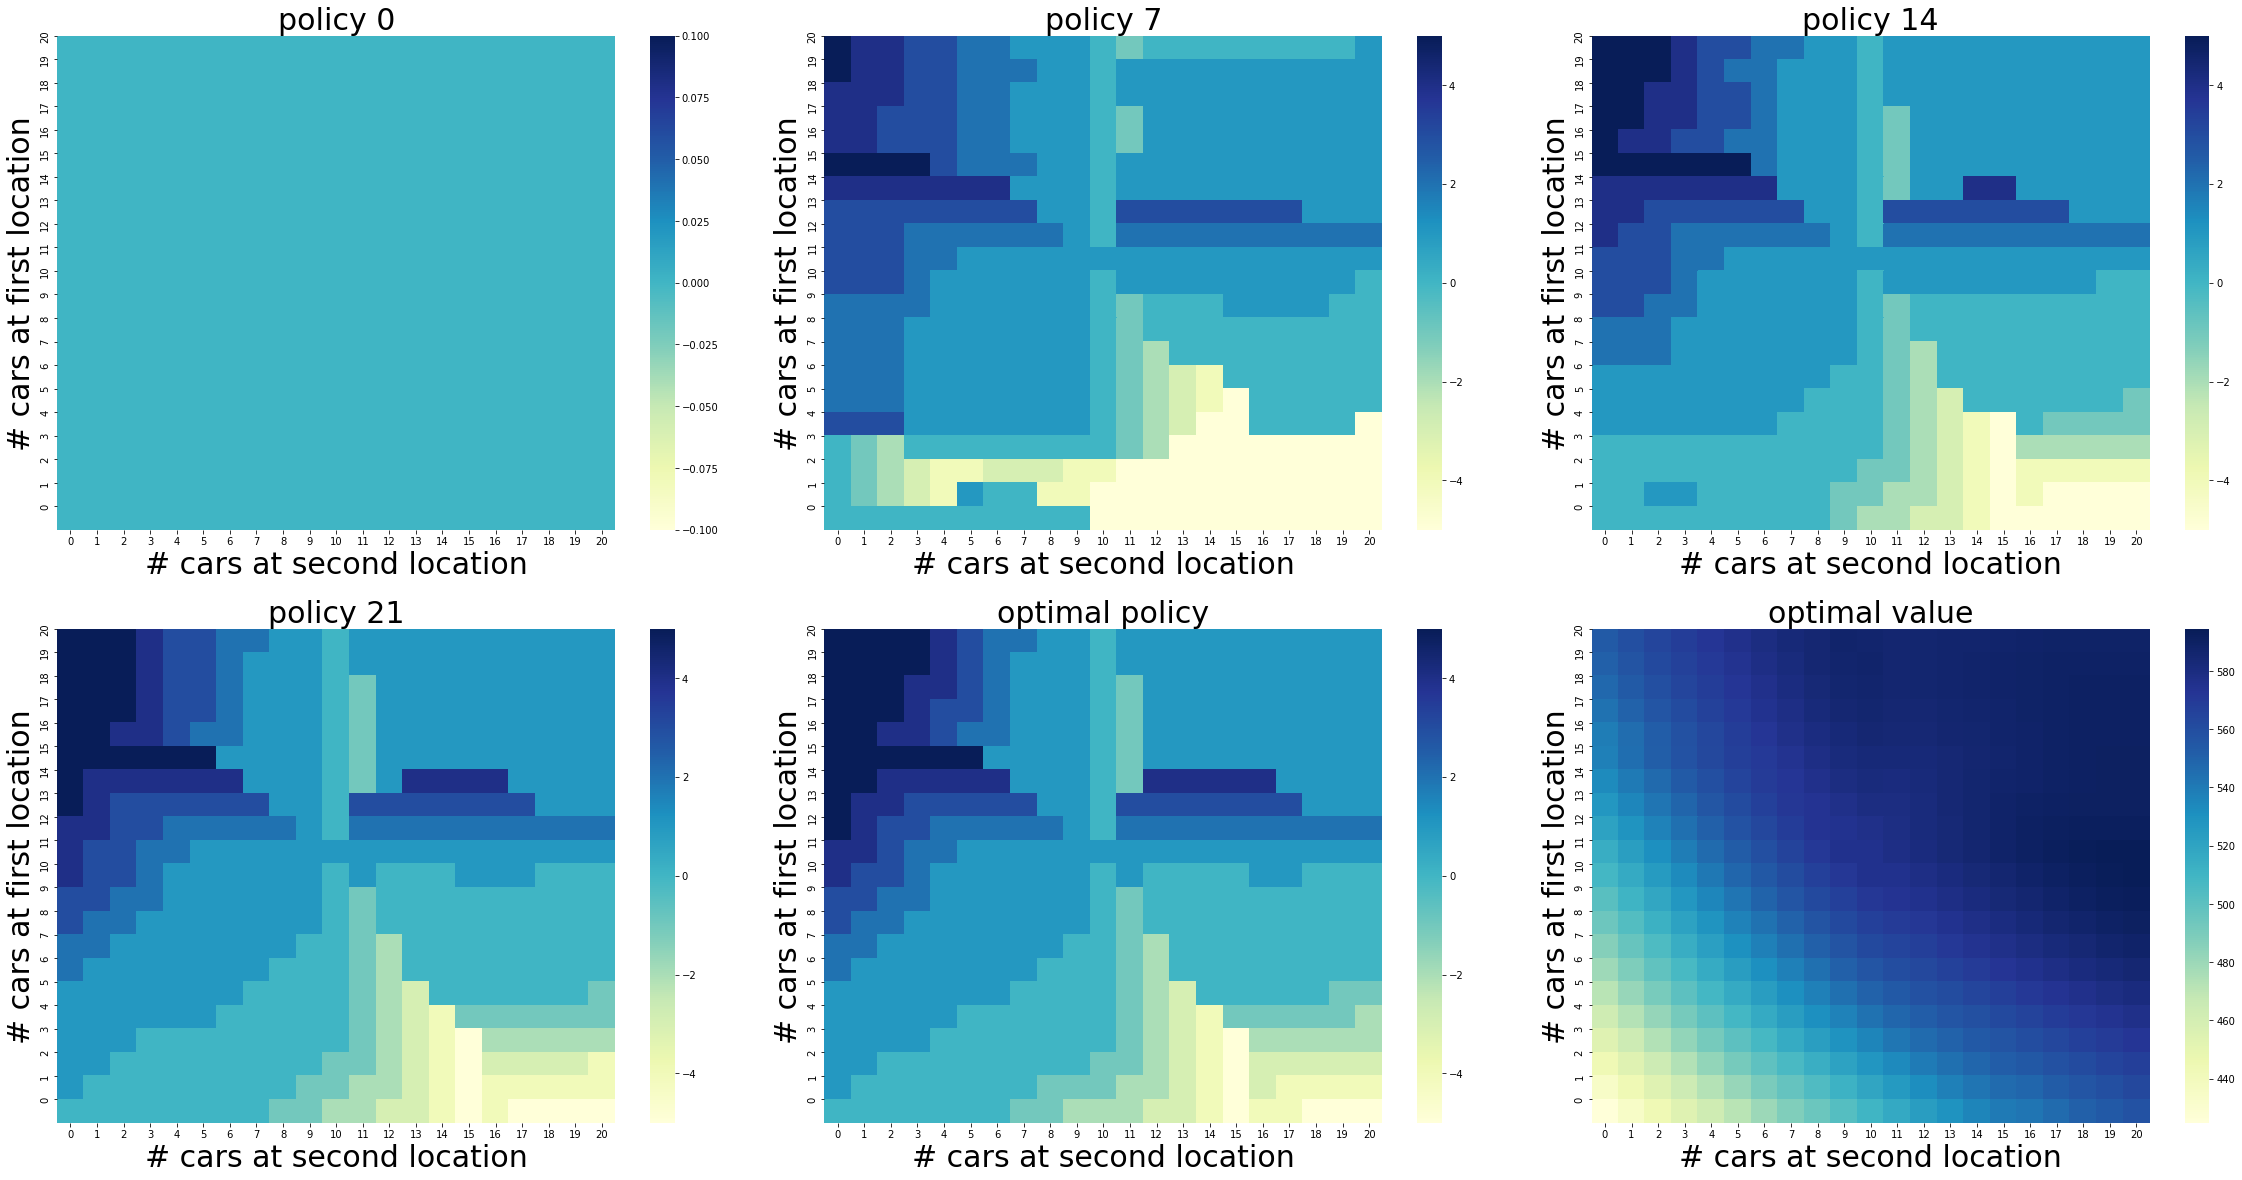

In [20]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An upper bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()




# max number of car in a single location
UPPER_BOUND_OVERNIGHT = 10

# additional cost to park the car in another parking lot if exceed the 
# UPPER_BOUND_OVERNIGHT limit
ADDITIONAL_NIGHT_COST = 4






def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initialize total return
    returns = 0.0
    
    # cost for moving cars
    if (action > 0):
      # if action is positive then move car from location 1 to location 2. Remove
      # the cost of moving one car thanks to the employee
      returns -= MOVE_CAR_COST * (action - 1)
    else:
      # if action is positive then move car from location 2 to location 1
      returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # additional cost for having exceeded the upper bound of cars in each parking lot
    if NUM_OF_CARS_FIRST_LOC > UPPER_BOUND_OVERNIGHT:
        returns -= ADDITIONAL_NIGHT_COST
    if NUM_OF_CARS_SECOND_LOC > UPPER_BOUND_OVERNIGHT:
        returns -= ADDITIONAL_NIGHT_COST

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

# This is the parameter of the function in the original code
constant_returned_cars = True

value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

policy = np.zeros(value.shape, dtype=int)

iterations = 0
_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

ind = 0

while True:

    if iterations in (0,7,14,21):
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[ind])
        ind += 1
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)
    
    old_value = value.copy()
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            action_returns = []
            for action in actions:
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                else:
                    action_returns.append(-np.inf)
            value[i, j] = np.max(action_returns)
            policy[i, j] = actions[np.argmax(action_returns)]
    max_value_change = abs(old_value - value).max()
    print('max value change {}'.format(max_value_change))
    # termination condition
    if max_value_change < 1e-4:
        break
        
    iterations += 1


fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-2])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal policy', fontsize=30)



fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal value', fontsize=30)

plt.show()


# Code for value iteration algorithm and figures
OPTIONAL_POINT = False








#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# ------------------------------------------------------------------------------



# OPTIONAL ASSIGNMENT



#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()

# cost if you have more that MAX_CARS
COST_MOVING_EXCEEDING_CARS = 4


def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initialize total return
    returns = 0.0
    
    # cost for moving cars
    if (action > 0):
      # if action is positive then move car from location 1 to location 2. Remove
      # the cost of moving one car thanks to the employee
      returns -= MOVE_CAR_COST * (action - 1)
    else:
      returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # additional cost for having exceeded the upper bound of cars in each parking lot
    if NUM_OF_CARS_FIRST_LOC > UPPER_BOUND_OVERNIGHT:
        returns -= ADDITIONAL_NIGHT_COST
    if NUM_OF_CARS_SECOND_LOC > UPPER_BOUND_OVERNIGHT:
        returns -= ADDITIONAL_NIGHT_COST

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC

                # if in a parking lot are returned more cars that it can handle
                # then the exceeding cars must be moved to another parking lot 
                # with a cost defined by COST_MOVING_EXCEEDING_CARS
                if (num_of_cars_first_loc + returned_cars_first_loc) > MAX_CARS:
                    reward -= COST_MOVING_EXCEEDING_CARS
                if (num_of_cars_second_loc + returned_cars_second_loc) > MAX_CARS:
                    reward -= COST_MOVING_EXCEEDING_CARS

                # leave in the location the max number of cars it can contains
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)


                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)

                        # same thing done in the other if case
                        if (num_of_cars_first_loc + returned_cars_first_loc) > MAX_CARS:
                            reward -= COST_MOVING_EXCEEDING_CARS
                        if (num_of_cars_second_loc + returned_cars_second_loc) > MAX_CARS:
                            reward -= COST_MOVING_EXCEEDING_CARS

                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)


                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

# This is the parameter of the function in the original code
constant_returned_cars = True

# array of value for every state
value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# policy for every state
policy = np.zeros(value.shape, dtype=int)

# variable to keep track about the number of value evaluation done (and also
# the number of time the policy is updated)
iterations = 0

# variable to print each of the iteration selected
ind = 0


_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

while True:

    # plot the selected iterations
    if iterations in (0,7,14,21):
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[ind])
        ind += 1
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)
    
    # save the previous value
    old_value = value.copy()
    # for every action in the modeò
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            action_returns = []
            for action in actions:
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                else:
                    action_returns.append(-np.inf)
            # update the value with the greatest return
            value[i, j] = np.max(action_returns)
            # update the policy with the action that give the greatest return
            policy[i, j] = actions[np.argmax(action_returns)]
    # get the maximum change in the iteration
    max_value_change = abs(old_value - value).max()
    print('max value change {}'.format(max_value_change))
    # termination condition
    if max_value_change < 1e-4:
        break
        
    iterations += 1

# plot the optimal policy
fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-2])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal policy', fontsize=30)

# plot the optimal policy 
fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal value', fontsize=30)

plt.show()


# Code for value iteration algorithm and figures
OPTIONAL_POINT = True

In [21]:
# HERE ENDS THE SECOND EXERCISE
assert policy.shape == (21, 21)

Comment your results in the cell below. Can you give an intuitive explanation for the optimal policy you found? [~15 lines]

**OPTIMAL_POINT = False**

We can see that thanks to the free move from the first location to the second location the model will generally try to move car from 1 to 2 respect to 2 to 1.
It's easy to see it in the states where the first location is full and the policy is to move one car to the second location, however when the second location is full the optimal policy is to not move any car. 

The behaviour of generally moving cars from the first location to the second could be given by the expectation of returned and rented cars in each location.
The first location has more cars returned in expectation and less rented, meanwhile it's the contrary for the second location. More cars arrives at 1 but more cars are rented at 2 so the model move the cars from 1 to 2 to allow 1 to recive other cars and 2 to rent more cars at the customers.

We can see that the 1 action is more probable respect to the -1 action because of the reasons described above: I can move for free a car from 1 to 2 and if the second location is has more car given that the move is not free and the expectation for renting is higher is reasonable to not move any car and wait that the cars are rented.

It is possible to see that when a location it's just above the limit of ten cars the model tries to move exceeding car to the other location in order to pay only one further location and not two. We can see that this behaviour is 'broken' (there is a hole that does nothing or move just one car) when one location has just more that 10 cars and the other just under 10 cars in order to avoid to have more that 10 cars in each location.

**OPTIMAL_POINT = True**

This is similar to the previous policy but now tries to move always from 1 to 2 if there are many cars in both location. 